# 4.0_SynAnalyzer_PlotSynAnalysis_Ntng1NIHL.ipynb
Created by: JFranco | 6 AUG 2024 | Env: SynCounting | Last run: 30 SEP 2024

This Python notebook is in the Synapse Analyzer pipeline. The purpose of the notebook is to plot the results of the SynAnalyzer.ijm

In [1]:
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
import math
from scipy import stats
from scipy.stats import ks_2samp

In [2]:
#                   *** GET TIME OF ANALYSIS START ***
# could turn this into a module?
toa = str(datetime.datetime.today()).split()                                   #Time of analysis
today = toa[0]
now = toa[1]
timestamp = today.replace('-','')+'-'+now.replace(':','')[:6]

In [3]:
#                *** WHAT TO ANALYZE // WHERE TO GET/STORE **
# Key identifiers
batchID = 'Ntng1NIHL_SynAnalyzer'
# Metadata fields to grab from the imaging metadata sheet & transfer to the image summary sheet
mdIFields = ['SlideID','Freq','NoHCRecon']
# Metadata fields to grab from the sample sheet & transfer to the image summary sheet
mdSFields = ['AnimalID','Sex','DOB','Genotype','Treatment','NoiseExposed']
# Surfaces to include in the analysis
surfs = ['PreSyn','PostSyn']
# Define condition (used for plotting) - Variables declared above and pasted here for reference
#   The base level code is setup to test up to two different condition sets
#   If only condition set is used, the variables may appear redundant
condToTest = ['NoiseExposed']
#condOneVals = ['Uninjected','mTagBFP','HABclw']
condTwoVals = ['Sham','Exposed']
conditions = ['Sham','Exposed']
# Parameters for plotting
pltOrder = conditions
colors = {pltOrder[0]:'teal' , pltOrder[1]:'darkorange'}
ecdfColors = ['teal','darkorange']
# tdTom(+) threshold - Threshold for a synapse to be considered associated with tdTom+ fiber
tdTomThre = 0.18

# Directories 
#   existing ones 
dirMain = '/Users/joyfranco/Partners HealthCare Dropbox/Joy Franco/JF_Shared/Data/FromCollaborators/Copeland2024/'
dirBA = dirMain+batchID+'/'
dirMD = dirBA+'Metadata/'
dirSA = dirBA+'SAR.Analysis/'

#   ones that need to be made    
dirRes = dirBA+'SAR.Results/'
dirTR = dirRes+timestamp+'/'

# Files to access
fnMDSamp = batchID+'.Metadata.Samples.csv'
fnMDIms = batchID+'.Metadata.Imaging.csv'
fnBM = 'SynAnalyzerBatchMaster.csv'

# Files to make
fnSS = batchID+'.ImageSummarySheet.csv'

In [4]:
#  *** INITIALIZE RUN SPECIFIC DIRECTORY ETC FOR STORING RESULTS **
# Create directory for storing spreadsheetS and summary plotS for this run
if not os.path.exists(dirRes): os.mkdir(dirRes)
if not os.path.exists(dirTR): os.mkdir(dirTR)

In [5]:
#  *** LOAD METADATA AND BATCH MASTER FILES ***
dfSamps = pd.read_csv(dirMD+fnMDSamp)
dfSamps.reset_index(inplace=True)
dfSamps.drop('index', axis=1, inplace=True)
dfIms = pd.read_csv(dirMD+fnMDIms)
dfIms.reset_index(inplace=True)
dfIms.drop('index', axis=1, inplace=True)
dfBM = pd.read_csv(dirSA+fnBM)
dfBM.reset_index(inplace=True)

In [6]:
#  *** COMPILE XYZ DATA ***
# Initialize a data frame for storing information for every sample 
dfISS = pd.DataFrame()
# Initialize a data frame for storying all XYZ data
dfXYZAll = pd.DataFrame()
# Iterate through the available XYZ sheets from SynAnalyzer to compile the results
imList = dfIms['ImageName']
for im in imList:
    # Get the index of the image in Ims MD df
    inIm = dfIms.index[dfIms['ImageName']==im].tolist()[0]
    # Check that the image has reconstructed hair cells
    noHCRecon = dfIms.loc[inIm]['NoHCRecon']
    if not (math.isnan(noHCRecon)):
        # For images that have valid hair cell reconstructed information --->
        # Get other key information from imaging MD sheet
        samp = dfIms.loc[inIm]['SlideID']
        freq = dfIms.loc[inIm]['Freq']
        noHC = dfIms.loc[inIm]['NoHCRecon']
        # Geet information from sample MD sheet
        inSamp = dfSamps.index[dfSamps['SampleID']==samp].tolist()[0]
        animalID = dfSamps.loc[inSamp]['AnimalID']
        sex = dfSamps.loc[inSamp]['Sex']
        dob = dfSamps.loc[inSamp]['DOB']
        geno = dfSamps.loc[inSamp]['Genotype']
        treat = dfSamps.loc[inSamp]['Treatment']
        neStatus = dfSamps.loc[inSamp]['NoiseExposed']
        
               
        # Define condition (used for plotting) - Variables declared above and pasted here for reference
        #condTwoVals = ['Sham','Exposed']
        #conditions = ['Sham','Exposed']
        if (neStatus == condTwoVals[0]):
            # Condition = Uninjected Sham 
            cond = conditions[0]
        elif (neStatus == condTwoVals[1]):
            # Condition = Uninjected Exposed 
            cond = conditions[1]

        # Setup the df for this image to add to add to dfISS
        df = pd.DataFrame({'ImageName': im, 
                           'SampleID':samp, 
                           'Frequency':[freq],
                           'NoHCRecon':[noHC],
                           'AnimalID':animalID,
                           'Sex':sex,
                           'DOB':dob,
                           'Genotype':geno,
                           'Treatment':treat,
                           'NoiseExposed':neStatus,
                           'Condition':cond})   

        # Iterate through surfs for this image to capture 
        i = 0
        for surf in surfs:
            # Setup the filename to open
            fnXYZ = im+'.XYZ.'+surf+'.csv'
            if os.path.exists(dirSA+fnXYZ):
                # Load the XYZ data
                dfXYZ = pd.read_csv(dirSA+fnXYZ)
                # Add important md to each row
                dfXYZ['ImageName']=im
                dfXYZ['SampleID']=samp
                dfXYZ['Frequency']=freq
                dfXYZ['Surf']=surf
                dfXYZ['Condition']=cond

                # Correct for the pillar-modiolar status bug
                if 'Pillar-ModiolarStatus' in dfXYZ.columns:
                    dfXYZ['PillarModiolarStatus']=dfXYZ['Pillar-ModiolarStatus']
                    xyzs = dfXYZ['ID']
                    for id in xyzs:
                        inID = dfXYZ.index[dfXYZ['ID']==id].tolist()[0]
                        pmStatus = dfXYZ.loc[inID]['PillarModiolarStatus']
                        if(pmStatus=='0'):
                            dfXYZ.at[inID, 'PillarModiolarStatus']='Pillar'
                    
                # Count the number of surfaces and categories
                nAll = len(dfXYZ)
                nSyns = len(dfXYZ[dfXYZ['SynapseStatus']==('Synapse' or 'Doublet')])
                nOrph = len(dfXYZ[dfXYZ['SynapseStatus']==('Orphan')])
                nPill = len(dfXYZ[(dfXYZ['PillarModiolarStatus']==('Pillar')) & (dfXYZ['SynapseStatus']==('Synapse' or 'Doublet'))])
                nMod = len(dfXYZ[(dfXYZ['PillarModiolarStatus']==('Modiolar')) & (dfXYZ['SynapseStatus']==('Synapse' or 'Doublet'))])
                uVol = dfXYZ['Volume_um3'].mean()
                uCh1 = dfXYZ['uIntCh_1'].mean()
                uCh2 = dfXYZ['uIntCh_2'].mean()
                uCh3 = dfXYZ['uIntCh_3'].mean()
                uCh4 = dfXYZ['uIntCh_4'].mean()
                maxCh4 = dfXYZ['uIntCh_4'].max()
                maxVol = dfXYZ['Volume_um3'].max()
                
                # Add summary data to image df
                df[surf+'_Total']=nAll
                df[surf+'_nSyns']=nSyns
                df[surf+'_nOrph']=nOrph
                df[surf+'_nPill']=nPill
                df[surf+'_nMod']=nMod
                df['Avg_'+surf+'_SynPerHC']=nSyns/noHC
                df[surf+'_PropPill']=nPill/nSyns
                df[surf+'_PropMod']=nMod/nSyns
                df[surf+'_uVol_um3']= uVol
                df[surf+'_uIntCh1']= uCh1
                df[surf+'_uIntCh2']= uCh2
                df[surf+'_uIntCh3']= uCh3
                df[surf+'_uIntCh4']= uCh4
                df[surf+'_maxIntCh4']= maxCh4
                df[surf+'_maxVol_um3']= maxVol

                # Calculate the mean normalized vals for each surface
                dfXYZ['uNormVol'] = dfXYZ['Volume_um3']/uVol
                dfXYZ['uNormIntCh1'] = dfXYZ['uIntCh_1']/uCh1
                dfXYZ['uNormIntCh2'] = dfXYZ['uIntCh_2']/uCh2
                dfXYZ['uNormIntCh3'] = dfXYZ['uIntCh_3']/uCh3
                dfXYZ['uNormIntCh4'] = dfXYZ['uIntCh_4']/uCh4
                dfXYZ['maxNormIntCh4'] = dfXYZ['uIntCh_4']/maxCh4
                dfXYZ['maxNormVol'] = dfXYZ['Volume_um3']/maxVol

                # Assign tdTom status based on maxCh43
                xyzs = dfXYZ['ID']
                if(surf=='PostSyn'):
                    for id in xyzs:
                        inID = dfXYZ.index[dfXYZ['ID']==id].tolist()[0]
                        maxInt = dfXYZ.loc[inID]['maxNormIntCh4']
                        if(maxInt>tdTomThre):
                            dfXYZ.at[inID, 'tdTomStat']='Positive'
                        else:
                            dfXYZ.at[inID, 'tdTomStat']='Negative'
                else:
                    dfXYZ['tdTomStat']='NA'

                nTdTomPos = len(dfXYZ[(dfXYZ['tdTomStat']==('Positive')) & (dfXYZ['SynapseStatus']==('Synapse' or 'Doublet'))])
                df[surf+'_nTdTom']=nTdTomPos
                df[surf+'_PropTdTomPos']=nTdTomPos/nSyns
                
                # Add it to the main df
                dfXYZAll = pd.concat([dfXYZAll,dfXYZ])
                i = i+1
            if(i==2):
                # Add information to the image summary sheet df
                dfISS = pd.concat([dfISS,df])

In [7]:
# Save the updated sheets
dfXYZAll.to_csv(dirTR+batchID+'.XYZSummary.csv') 
dfISS.to_csv(dirTR+batchID+'.ImageSummary.csv') 

### GENERATE PLOTS

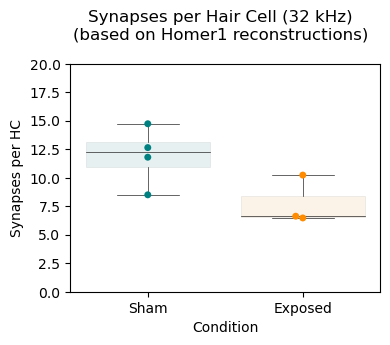

In [8]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PostSyn_AvgSynPerHC'
plottype = 'BoxSwarm'
region = 32
title = 'Synapses per Hair Cell ('+str(region)+' kHz)\n(based on Homer1 reconstructions)'
hue = 'Condition'
x = 'Condition'
y = 'Avg_PostSyn_SynPerHC'
ymin = 0
ymax = 20
xlab = 'Condition'
ylab = 'Synapses per HC'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

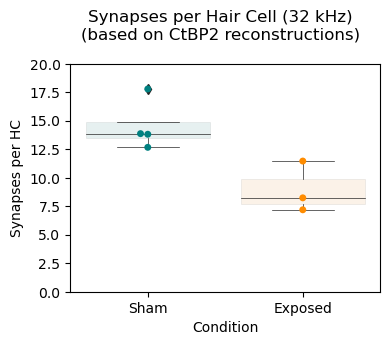

In [9]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSyn_AvgSynPerHC'
plottype = 'BoxSwarm'
region = 32
title = 'Synapses per Hair Cell ('+str(region)+' kHz)\n(based on CtBP2 reconstructions)'
hue = 'Condition'
x = 'Condition'
y = 'Avg_PreSyn_SynPerHC'
ymin = 0
ymax = 20
xlab = 'Condition'
ylab = 'Synapses per HC'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

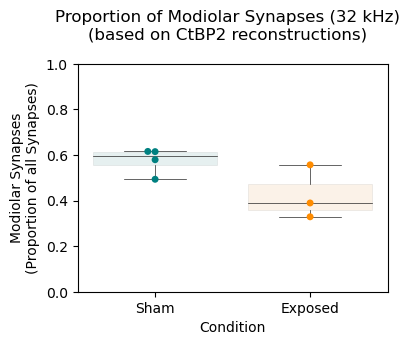

In [10]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSyn_PropModSyns'
plottype = 'BoxSwarm'
region = 32
title = 'Proportion of Modiolar Synapses ('+str(region)+' kHz)\n(based on CtBP2 reconstructions)'
hue = 'Condition'
x = 'Condition'
y = 'PreSyn_PropMod'
ymin = 0
ymax = 1
xlab = 'Condition'
ylab = 'Modiolar Synapses\n(Proportion of all Synapses)'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

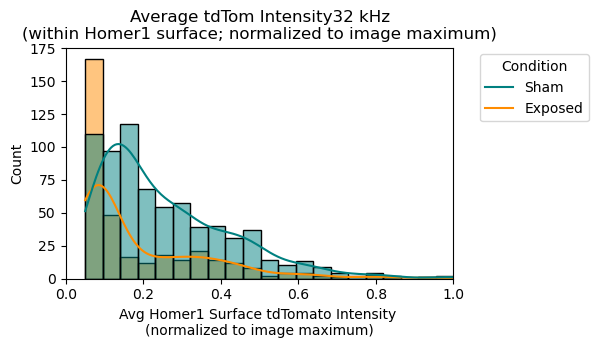

In [11]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PostSyn_MaxNormTdTomInt'
plottype = 'Hist'
region = 32
title = 'Average tdTom Intensity'+str(region)+' kHz\n(within Homer1 surface; normalized to image maximum)'
surfType = 'PostSyn'
hue = 'Condition'
x = 'maxNormIntCh4'
xmin = 0
xmax = 1
xlab = 'Avg Homer1 Surface tdTomato Intensity \n(normalized to image maximum)'
ylab = 'Count'

# *** MAKE PLOT ***
plt.figure(figsize=(5, 3))
ax = sns.histplot(data=dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&(dfXYZAll['SynapseStatus']=='Synapse')],x=x, hue=hue, hue_order=pltOrder,  palette=colors,kde=True)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
ax.set_xlim((xmin, xmax))
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 2):
    leg.legend_handles[i].set_color(ecdfColors[i])
    
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

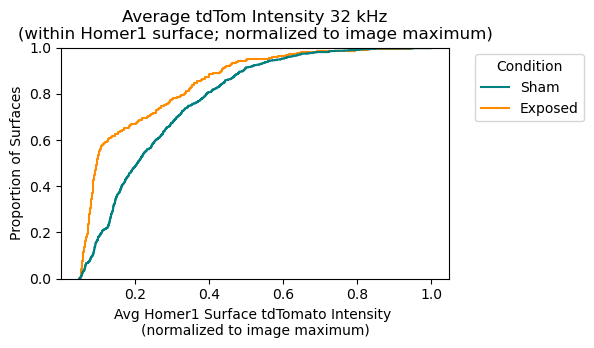

In [12]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PostSyn_MaxNormTdTomInt'
plottype = 'ECDF'
region = 32
title = 'Average tdTom Intensity '+str(region)+' kHz\n(within Homer1 surface; normalized to image maximum)'
surfType = 'PostSyn'
hue = 'Condition'
x = 'maxNormIntCh4'
xlab = 'Avg Homer1 Surface tdTomato Intensity \n(normalized to image maximum)'
ylab = 'Proportion of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(5, 3))
ax = sns.ecdfplot(data=dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&(dfXYZAll['SynapseStatus']=='Synapse')],x=x, hue=hue, palette=colors)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 2):
    leg.legend_handles[i].set_color(ecdfColors[i])
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.svg',  bbox_inches='tight', dpi = 300,format = 'svg')

In [44]:
# *** RUNNNING THE STATS ***
region = 32
surfType = 'PostSyn'
# Subset the dataframe for each condition
df_Sham = dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&
                    (dfXYZAll['SynapseStatus']=='Synapse')&(dfXYZAll['Condition']=='Sham')]
df_Exp = dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&
                    (dfXYZAll['SynapseStatus']=='Synapse')&(dfXYZAll['Condition']=='Exposed')]
# *Perform KS tests to compare*
# Comparing WT and KO vehicle treated
ks, pvalue = ks_2samp(df_Sham['maxNormIntCh4'], df_Exp['maxNormIntCh4'])

print('Statistical analysis of tdTom intensity within Homer1 Surface\n'+
      'Sham v Exposed p-value = '+ str(pvalue))

Statistical analysis of tdTom intensity within Homer1 Surface
Sham v Exposed p-value = 1.5717769747781493e-30


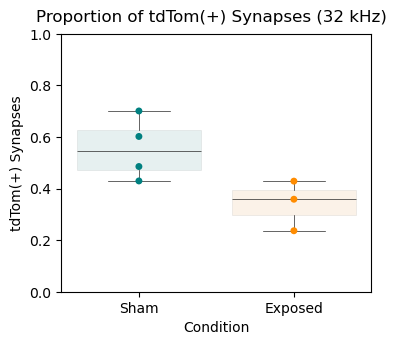

In [45]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PostSyn_PropTdTomPos'
plottype = 'BoxSwarm'
region = 32
title = 'Proportion of tdTom(+) Synapses ('+str(region)+' kHz)'
hue = 'Condition'
x = 'Condition'
y = 'PostSyn_PropTdTomPos'
ymin = 0
ymax = 1
xlab = 'Condition'
ylab = 'tdTom(+) Synapses'

# *** MAKE PLOT ***
fig= plt.figure(figsize=(4,3))
plt.subplots_adjust(top = 0.9, bottom=0.04, hspace=.3, wspace=.2)
fig.suptitle(title)
ax1 = sns.swarmplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y=y, hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
ax1.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax1.get_legend().remove()

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

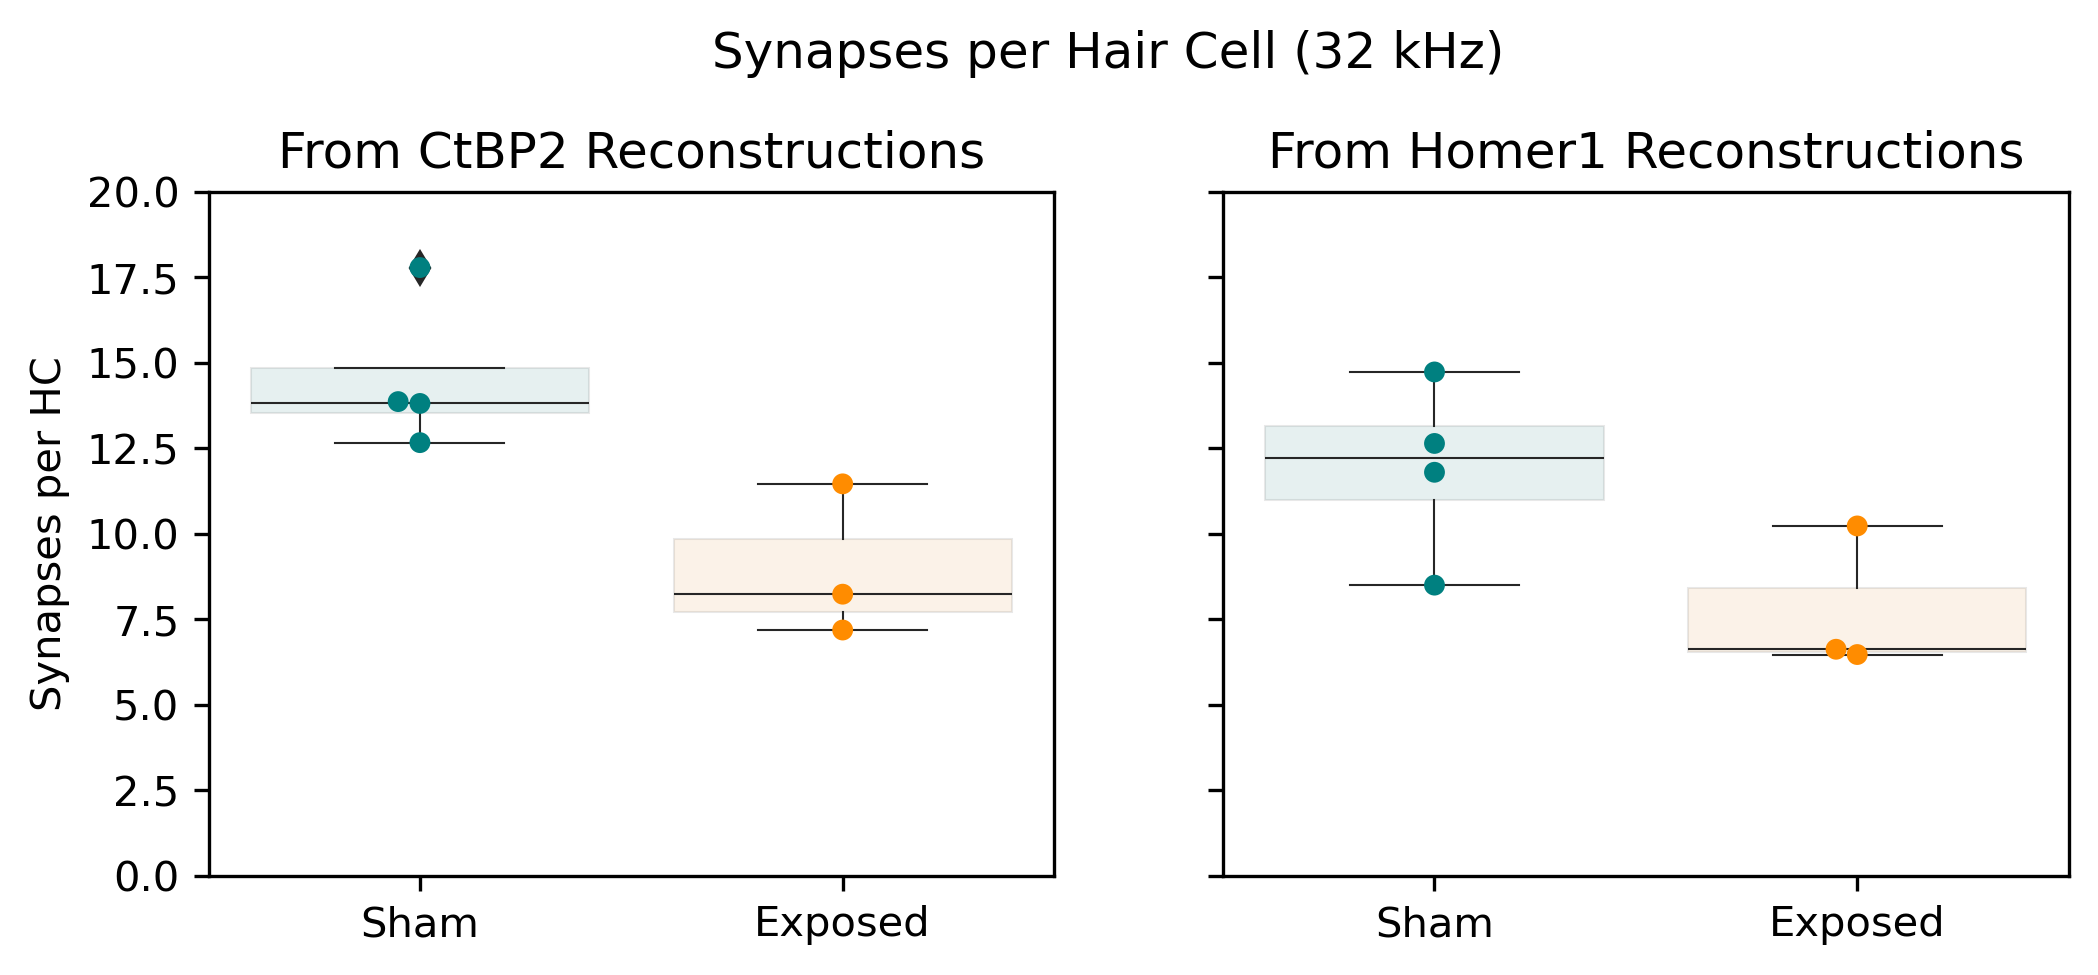

In [46]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'AvgSynPerHC'
plottype = 'BoxSwarm'
region = 32
title = 'Synapses per Hair Cell ('+str(region)+' kHz)'
hue = 'Condition'
x = 'Condition'
y = 'Avg_PreSyn_SynPerHC'
ymin = 0
ymax = 20
xlab = 'Condition'
ylab = 'Synapses per HC'

# *** MAKE PLOT ***
fig, axes = plt.subplots(1, 2, dpi=300,figsize=(8,3), sharex = True, sharey = True)
(ax1, ax2) = axes
fig.suptitle(title)
plt.subplots_adjust(top = 0.8, bottom=0.04, hspace=.3, wspace=.2)

ax1 = plt.subplot(121) 
ax1 = sns.swarmplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y='Avg_PreSyn_SynPerHC', hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y='Avg_PreSyn_SynPerHC', hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax1, dodge = False,linewidth=.5)
ax1.set_ylim((ymin, ymax))
#ax1.set(xlabel=xlab)
#ax1.set(ylabel=ylab)
ax1.set(xlabel='', ylabel=ylab)
ax1.get_legend().remove()
ax1.title.set_text('From CtBP2 Reconstructions')

ax2 = plt.subplot(122) 
ax2 = sns.swarmplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y='Avg_PostSyn_SynPerHC', hue=hue,palette=colors,order=pltOrder,legend = False, dodge = False)
sns.boxplot(data=dfISS[(dfISS['Frequency']==region)],x=x,y='Avg_PostSyn_SynPerHC', hue=hue,palette=colors,order=pltOrder,boxprops={'alpha': 0.1}, ax=ax2, dodge = False,linewidth=.5)
ax2.set(xlabel=xlab)
ax1.set(ylabel=ylab)
ax2.get_legend().remove()
ax2.set(xlabel='', ylabel='')
ax2.title.set_text('From Homer1 Reconstructions')

# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

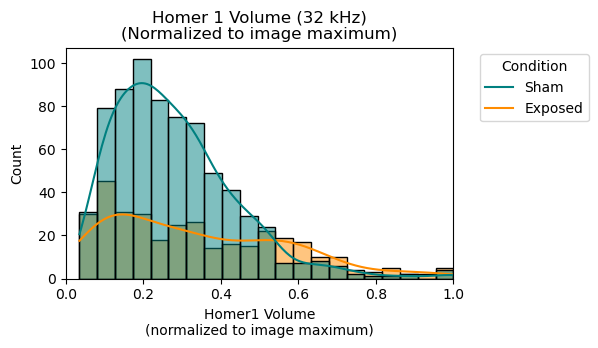

In [47]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PostSyn_MaxNormVol'
plottype = 'Hist'
region = 32
title = 'Homer 1 Volume ('+str(region)+' kHz)\n(Normalized to image maximum)'
surfType = 'PostSyn'
hue = 'Condition'
x = 'maxNormVol'
xmin = 0
xmax = 1
xlab = 'Homer1 Volume\n(normalized to image maximum)'
ylab = 'Count'

# *** MAKE PLOT ***
plt.figure(figsize=(5, 3))
ax = sns.histplot(data=dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&(dfXYZAll['SynapseStatus']=='Synapse')],x=x, hue=hue, hue_order=pltOrder,  palette=colors,kde=True)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
ax.set_xlim((xmin, xmax))
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 2):
    leg.legend_handles[i].set_color(ecdfColors[i])
    
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

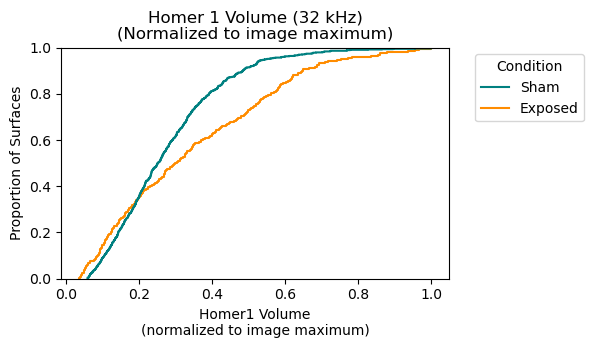

In [48]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PostSyn_MaxNormVol'
plottype = 'ECDF'
region = 32
title = 'Homer 1 Volume ('+str(region)+' kHz)\n(Normalized to image maximum)'
surfType = 'PostSyn'
hue = 'Condition'
x = 'maxNormVol'
xlab = 'Homer1 Volume\n(normalized to image maximum)'
ylab = 'Proportion of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(5, 3))
ax = sns.ecdfplot(data=dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&(dfXYZAll['SynapseStatus']=='Synapse')],x=x, hue=hue, palette=colors)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 2):
    leg.legend_handles[i].set_color(ecdfColors[i])
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

In [49]:
# *** RUNNNING THE STATS ***
region = 32
surfType = 'PostSyn'
# Subset the dataframe for each condition
df_Sham = dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&
                    (dfXYZAll['SynapseStatus']=='Synapse')&(dfXYZAll['Condition']=='Sham')]
df_Exp = dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&
                    (dfXYZAll['SynapseStatus']=='Synapse')&(dfXYZAll['Condition']=='Exposed')]
# *Perform KS tests to compare*
# Comparing WT and KO vehicle treated
ks, pvalue = ks_2samp(df_Sham['maxNormVol'], df_Exp['maxNormVol'])

print('Statistical analysis of Homer1 Surface Volume\n'+
      'Sham v Exposed p-value = '+ str(pvalue))

Statistical analysis of Homer1 Surface Volume
Sham v Exposed p-value = 8.092876145567868e-09


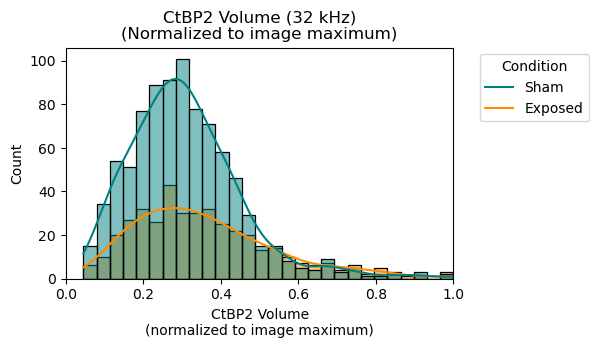

In [50]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSyn_MaxNormVol'
plottype = 'Hist'
region = 32
title = 'CtBP2 Volume ('+str(region)+' kHz)\n(Normalized to image maximum)'
surfType = 'PreSyn'
hue = 'Condition'
x = 'maxNormVol'
xmin = 0
xmax = 1
xlab = 'CtBP2 Volume\n(normalized to image maximum)'
ylab = 'Count'

# *** MAKE PLOT ***
plt.figure(figsize=(5, 3))
ax = sns.histplot(data=dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&(dfXYZAll['SynapseStatus']=='Synapse')],x=x, hue=hue, hue_order=pltOrder,  palette=colors,kde=True)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
ax.set_xlim((xmin, xmax))
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 2):
    leg.legend_handles[i].set_color(ecdfColors[i])
    
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

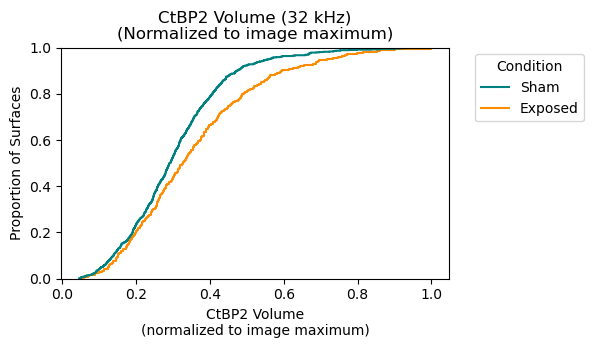

In [51]:
# *** SET PLOT SPECIFIC PARAMETERS ***
plot = 'PreSyn_MaxNormVol'
plottype = 'ECDF'
region = 32
title = 'CtBP2 Volume ('+str(region)+' kHz)\n(Normalized to image maximum)'
surfType = 'PreSyn'
hue = 'Condition'
x = 'maxNormVol'
xlab = 'CtBP2 Volume\n(normalized to image maximum)'
ylab = 'Proportion of Surfaces'

# *** MAKE PLOT ***
plt.figure(figsize=(5, 3))
ax = sns.ecdfplot(data=dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&(dfXYZAll['SynapseStatus']=='Synapse')],x=x, hue=hue, palette=colors)
ax.set_title(title)
ax.set(xlabel=xlab)
ax.set(ylabel=ylab)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left',  fancybox=True, labels=conditions)
leg = ax.get_legend()
noHandles = len(leg.legend_handles)
i=0
for i in range(0, 2):
    leg.legend_handles[i].set_color(ecdfColors[i])
# *** SAVE THE FIGURE ***
plt.savefig(dirTR+batchID+'.'+plot+'.'+plottype+'.'+str(region)+'.png',  bbox_inches='tight', dpi = 300,format = 'png')

In [52]:
# *** RUNNNING THE STATS ***
region = 32
surfType = 'PreSyn'
# Subset the dataframe for each condition
df_Sham = dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&
                    (dfXYZAll['SynapseStatus']=='Synapse')&(dfXYZAll['Condition']=='Sham')]
df_Exp = dfXYZAll[(dfXYZAll['Frequency']==region)&(dfXYZAll['Surf']==surfType)&
                    (dfXYZAll['SynapseStatus']=='Synapse')&(dfXYZAll['Condition']=='Exposed')]
# *Perform KS tests to compare*
# Comparing WT and KO vehicle treated
ks, pvalue = ks_2samp(df_Sham['maxNormVol'], df_Exp['maxNormVol'])

print('Statistical analysis of Homer1 Surface Volume\n'+
      'Sham v Exposed p-value = '+ str(pvalue))

Statistical analysis of Homer1 Surface Volume
Sham v Exposed p-value = 2.6623044665816895e-05


In [ ]:
Nt